### 모듈 불러오기

In [1]:
import tensorflow as tf
import numpy as np
from konlpy.tag import Twitter
import pandas as pd
import tensorflow as tf
import enum
import os
import re
import json
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import matplotlib.pyplot as plt
from preprocess import *

### 시각화 함수

In [2]:
def plot_graphs(history, string):
    plt.plot(history.history[string])
    plt.plot(history.history['val_'+string], '')
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.legend([string, 'val_'+string])
    plt.show()

### 학습 데이터 경로 정의

In [3]:
DATA_IN_PATH = './data_in/'
DATA_OUT_PATH = './data_out/'
TRAIN_INPUTS = 'train_inputs.npy'
TRAIN_OUTPUTS = 'train_outputs.npy'
TRAIN_TARGETS = 'train_targets.npy'
DATA_CONFIGS = 'data_configs.json'

### 랜덤 시드 고정

In [4]:
SEED_NUM = 1234
tf.random.set_seed(SEED_NUM)

### 파일 로드

In [5]:
index_inputs = np.load(open(DATA_IN_PATH + TRAIN_INPUTS, 'rb'))
index_outputs = np.load(open(DATA_IN_PATH + TRAIN_OUTPUTS , 'rb'))
index_targets = np.load(open(DATA_IN_PATH + TRAIN_TARGETS , 'rb'))
prepro_configs = json.load(open(DATA_IN_PATH + DATA_CONFIGS, 'r'))

### 모델 하이퍼파라메터 정의

In [6]:
char2idx = prepro_configs['char2idx']
end_index = prepro_configs['end_symbol']
model_name = 'transformer'
vocab_size = prepro_configs['vocab_size']
BATCH_SIZE = 64
MAX_SEQUENCE = 25
EPOCHS = 20
VALID_SPLIT = 0.1

kargs = {'model_name': model_name,
         'num_layers': 2,
         'd_model': 512,
         'num_heads': 8,
         'dff': 2048,
         'input_vocab_size': vocab_size,
         'target_vocab_size': vocab_size,
         'maximum_position_encoding': MAX_SEQUENCE,
         'end_token_idx': char2idx[end_index],
         'rate': 0.1
        }

### 모델 선언 및 컴파일

### 패딩 및 포워드 마스킹 

In [7]:
def create_padding_mask(seq):
    seq = tf.cast(tf.math.equal(seq, 0), tf.float32)

    return seq[:, tf.newaxis, tf.newaxis, :]

In [8]:
def create_look_ahead_mask(size):
    mask = 1 - tf.linalg.band_part(tf.ones((size, size)), -1, 0)

    return mask

In [9]:
def create_masks(inp, tar):
    enc_padding_mask = create_padding_mask(inp)
    dec_padding_mask = create_padding_mask(inp)
    look_ahead_mask = create_look_ahead_mask(tf.shape(tar)[1])
    dec_target_padding_mask = create_padding_mask(tar)
    combined_mask = tf.maximum(dec_target_padding_mask, look_ahead_mask)

    return enc_padding_mask, combined_mask, dec_padding_mask

In [10]:
enc_padding_mask, look_ahead_mask, dec_padding_mask = create_masks(index_inputs, index_outputs)

### 포지셔널 인코딩

In [11]:
def get_angles(pos, i, d_model):
    angle_rates = 1 / np.power(10000, (2 * i//2) / np.float32(d_model))

    return pos * angle_rates

In [12]:
def positional_encoding(position, d_model):
    angle_rads = get_angles(np.arange(position)[:, np.newaxis],
                          np.arange(d_model)[np.newaxis, :],
                          d_model)

    angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])
    angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])
    pos_encoding = angle_rads[np.newaxis, ...]

    return tf.cast(pos_encoding, dtype=tf.float32)

(1, 50, 512)


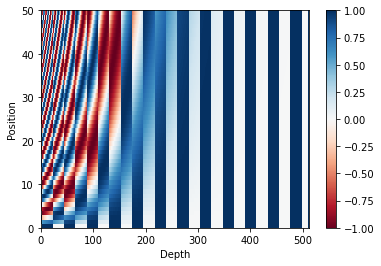

In [13]:
pos_encoding = positional_encoding(50, 512)

print (pos_encoding.shape)

plt.pcolormesh(pos_encoding[0], cmap='RdBu')
plt.xlabel('Depth')
plt.xlim((0, 512))
plt.ylabel('Position')
plt.colorbar()
plt.show()

### 어텐션

In [14]:
def scaled_dot_product_attention(q, k, v, mask):
    """Calculate the attention weights.
    q, k, v must have matching leading dimensions.
    k, v must have matching penultimate dimension, i.e.: seq_len_k = seq_len_v.
    The mask has different shapes depending on its type(padding or look ahead) 
    but it must be broadcastable for addition.

    Args:
    q: query shape == (..., seq_len_q, depth)
    k: key shape == (..., seq_len_k, depth)
    v: value shape == (..., seq_len_v, depth_v)
    mask: Float tensor with shape broadcastable 
          to (..., seq_len_q, seq_len_k). Defaults to None.

    Returns:
    output, attention_weights
    """

    matmul_qk = tf.matmul(q, k, transpose_b=True)
    dk = tf.cast(tf.shape(k)[-1], tf.float32)
    scaled_attention_logits = matmul_qk / tf.math.sqrt(dk)

    if mask is not None:
        scaled_attention_logits += (mask * -1e9)  

    attention_weights = tf.nn.softmax(scaled_attention_logits, axis=-1)  # (..., seq_len_q, seq_len_k)
    output = tf.matmul(attention_weights, v)  # (..., seq_len_q, depth_v)

    return output, attention_weights

### 멀티헤드 어텐션

In [15]:
class MultiHeadAttention(tf.keras.layers.Layer):
    def __init__(self, **kargs):
        super(MultiHeadAttention, self).__init__()
        self.num_heads = kargs['num_heads']
        self.d_model = kargs['d_model']

        assert self.d_model % self.num_heads == 0

        self.depth = self.d_model // self.num_heads

        self.wq = tf.keras.layers.Dense(kargs['d_model'])
        self.wk = tf.keras.layers.Dense(kargs['d_model'])
        self.wv = tf.keras.layers.Dense(kargs['d_model'])

        self.dense = tf.keras.layers.Dense(kargs['d_model'])

    def split_heads(self, x, batch_size):
        """Split the last dimension into (num_heads, depth).
        Transpose the result such that the shape is (batch_size, num_heads, seq_len, depth)
        """
        x = tf.reshape(x, (batch_size, -1, self.num_heads, self.depth))

        return tf.transpose(x, perm=[0, 2, 1, 3])

    def call(self, v, k, q, mask):
        batch_size = tf.shape(q)[0]

        q = self.wq(q) 
        k = self.wk(k) 
        v = self.wv(v) 

        q = self.split_heads(q, batch_size) 
        k = self.split_heads(k, batch_size) 
        v = self.split_heads(v, batch_size) 

        scaled_attention, attention_weights = scaled_dot_product_attention(q, k, v, mask)
        scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])
        concat_attention = tf.reshape(scaled_attention, (batch_size, -1, self.d_model))

        output = self.dense(concat_attention)

        return output, attention_weights

### 포인트 와이즈 피드포워드 네트워크 

In [16]:
def point_wise_feed_forward_network(**kargs):
    return tf.keras.Sequential([
      tf.keras.layers.Dense(kargs['dff'], activation='relu'),  
      tf.keras.layers.Dense(kargs['d_model'])
    ])

### 인코더 레이어

In [17]:
class EncoderLayer(tf.keras.layers.Layer):
    def __init__(self, **kargs):
        super(EncoderLayer, self).__init__()

        self.mha = MultiHeadAttention(**kargs)
        self.ffn = point_wise_feed_forward_network(**kargs)

        self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

        self.dropout1 = tf.keras.layers.Dropout(kargs['rate'])
        self.dropout2 = tf.keras.layers.Dropout(kargs['rate'])

    def call(self, x, mask):
        attn_output, _ = self.mha(x, x, x, mask)  # (batch_size, input_seq_len, d_model)
        attn_output = self.dropout1(attn_output)
        out1 = self.layernorm1(x + attn_output)  

        ffn_output = self.ffn(out1) 
        ffn_output = self.dropout2(ffn_output)
        out2 = self.layernorm2(out1 + ffn_output)  

        return out2

### 디코더 레이어

In [18]:
class DecoderLayer(tf.keras.layers.Layer):
    def __init__(self, **kargs):
        super(DecoderLayer, self).__init__()

        self.mha1 = MultiHeadAttention(**kargs)
        self.mha2 = MultiHeadAttention(**kargs)

        self.ffn = point_wise_feed_forward_network(**kargs)

        self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm3 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

        self.dropout1 = tf.keras.layers.Dropout(kargs['rate'])
        self.dropout2 = tf.keras.layers.Dropout(kargs['rate'])
        self.dropout3 = tf.keras.layers.Dropout(kargs['rate'])
    
    
    def call(self, x, enc_output, look_ahead_mask, padding_mask):
        attn1, attn_weights_block1 = self.mha1(x, x, x, look_ahead_mask)  
        attn1 = self.dropout1(attn1)
        out1 = self.layernorm1(attn1 + x)

        attn2, attn_weights_block2 = self.mha2(enc_output, enc_output, out1, padding_mask)  
        attn2 = self.dropout2(attn2)
        out2 = self.layernorm2(attn2 + out1) 

        ffn_output = self.ffn(out2) 
        ffn_output = self.dropout3(ffn_output)
        out3 = self.layernorm3(ffn_output + out2) 

        return out3, attn_weights_block1, attn_weights_block2

### 인코더

In [19]:
class Encoder(tf.keras.layers.Layer):
    def __init__(self, **kargs):
        super(Encoder, self).__init__()

        self.d_model = kargs['d_model']
        self.num_layers = kargs['num_layers']

        self.embedding = tf.keras.layers.Embedding(kargs['input_vocab_size'], self.d_model)
        self.pos_encoding = positional_encoding(kargs['maximum_position_encoding'], 
                                                self.d_model)


        self.enc_layers = [EncoderLayer(**kargs) for _ in range(self.num_layers)]

        self.dropout = tf.keras.layers.Dropout(kargs['rate'])

    def call(self, x, mask):

        seq_len = tf.shape(x)[1]

        x = self.embedding(x)
        x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
        x += self.pos_encoding[:, :seq_len, :]

        x = self.dropout(x)

        for i in range(self.num_layers):
            x = self.enc_layers[i](x, mask)

        return x 

### 디코더

In [20]:
class Decoder(tf.keras.layers.Layer):
    def __init__(self, **kargs):
        super(Decoder, self).__init__()

        self.d_model = kargs['d_model']
        self.num_layers = kargs['num_layers']

        self.embedding = tf.keras.layers.Embedding(kargs['target_vocab_size'], self.d_model)
        self.pos_encoding = positional_encoding(kargs['maximum_position_encoding'], self.d_model)

        self.dec_layers = [DecoderLayer(**kargs) 
                           for _ in range(self.num_layers)]
        self.dropout = tf.keras.layers.Dropout(kargs['rate'])

    def call(self, x, enc_output, look_ahead_mask, padding_mask):
        seq_len = tf.shape(x)[1]
        attention_weights = {}

        x = self.embedding(x)  # (batch_size, target_seq_len, d_model)
        x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
        x += self.pos_encoding[:, :seq_len, :]

        x = self.dropout(x)

        for i in range(self.num_layers):
            x, block1, block2 = self.dec_layers[i](x, enc_output, look_ahead_mask, padding_mask)

            attention_weights['decoder_layer{}_block1'.format(i+1)] = block1
            attention_weights['decoder_layer{}_block2'.format(i+1)] = block2

        return x, attention_weights

### 트렌스포머 모델

In [21]:
class Transformer(tf.keras.Model):
    def __init__(self, **kargs):
        super(Transformer, self).__init__(name=kargs['model_name'])
        self.end_token_idx = kargs['end_token_idx']
        
        self.encoder = Encoder(**kargs)
        self.decoder = Decoder(**kargs)

        self.final_layer = tf.keras.layers.Dense(kargs['target_vocab_size'])

    def call(self, x):
        inp, tar = x

        enc_padding_mask, look_ahead_mask, dec_padding_mask = create_masks(inp, tar)
        enc_output = self.encoder(inp, enc_padding_mask)

        dec_output, _ = self.decoder(tar, enc_output, look_ahead_mask, dec_padding_mask)

        final_output = self.final_layer(dec_output)

        return final_output
    
    def inference(self, x):
        inp = x
        tar = tf.expand_dims([STD_INDEX], 0)

        enc_padding_mask, look_ahead_mask, dec_padding_mask = create_masks(inp, tar)        
        enc_output = self.encoder(inp, enc_padding_mask)
        
        predict_tokens = list()
        
        for t in range(0, MAX_SEQUENCE):
            dec_output, _ = self.decoder(tar, enc_output, look_ahead_mask, dec_padding_mask)
            final_output = self.final_layer(dec_output)
            outputs = tf.argmax(final_output, -1).numpy()
            pred_token = outputs[0][-1]
            
            if pred_token == self.end_token_idx:
                break
                
            predict_tokens.append(pred_token)
            tar = tf.expand_dims([STD_INDEX] + predict_tokens, 0)
            _, look_ahead_mask, dec_padding_mask = create_masks(inp, tar)
            
        return predict_tokens

### 모델 로스 정의

In [22]:
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='none')

train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='accuracy')

def loss(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)

    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask

    return tf.reduce_mean(loss_)

def accuracy(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    mask = tf.expand_dims(tf.cast(mask, dtype=pred.dtype), axis=-1)
    pred *= mask    
    acc = train_accuracy(real, pred)

    return tf.reduce_mean(acc)

In [23]:
model = Transformer(**kargs)
model.compile(optimizer=tf.keras.optimizers.Adam(1e-4),
              loss=loss,
              metrics=[accuracy])

### Callback 선언

In [24]:
earlystop_callback = EarlyStopping(monitor='val_accuracy', min_delta=0.0001, patience=10)

checkpoint_path = DATA_OUT_PATH + model_name + '/weights.h5'
checkpoint_dir = os.path.dirname(checkpoint_path)

if os.path.exists(checkpoint_dir):
    print("{} -- Folder already exists \n".format(checkpoint_dir))
else:
    os.makedirs(checkpoint_dir, exist_ok=True)
    print("{} -- Folder create complete \n".format(checkpoint_dir))
    
cp_callback = ModelCheckpoint(
    checkpoint_path, monitor='val_accuracy', verbose=1, save_best_only=True, save_weights_only=True)

./data_out/transformer -- Folder already exists 



### 모델 학습

In [25]:
history = model.fit([index_inputs, index_outputs], index_targets, 
                    batch_size=BATCH_SIZE, epochs=EPOCHS,
                    validation_split=VALID_SPLIT, callbacks=[earlystop_callback, cp_callback])

Train on 10640 samples, validate on 1183 samples
Epoch 1/20
10624/10640 [============================>.] - ETA: 0s - loss: 1.6125 - accuracy: 0.8072
Epoch 00001: val_accuracy improved from -inf to 0.80749, saving model to ./data_out/transformer/weights.h5
10640/10640 [==============================] - 31s 3ms/sample - loss: 1.6118 - accuracy: 0.8072 - val_loss: 1.6914 - val_accuracy: 0.8075
Epoch 2/20
10624/10640 [============================>.] - ETA: 0s - loss: 1.3540 - accuracy: 0.8085
Epoch 00002: val_accuracy improved from 0.80749 to 0.81077, saving model to ./data_out/transformer/weights.h5
10640/10640 [==============================] - 24s 2ms/sample - loss: 1.3537 - accuracy: 0.8086 - val_loss: 1.5931 - val_accuracy: 0.8108
Epoch 3/20
10624/10640 [============================>.] - ETA: 0s - loss: 1.2249 - accuracy: 0.8138
Epoch 00003: val_accuracy improved from 0.81077 to 0.81638, saving model to ./data_out/transformer/weights.h5
10640/10640 [==============================] - 2

### 결과 플롯

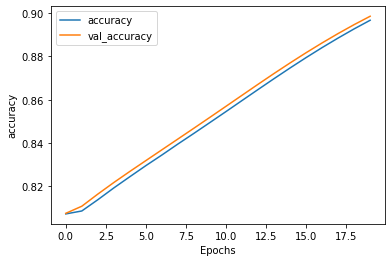

In [26]:
plot_graphs(history, 'accuracy')

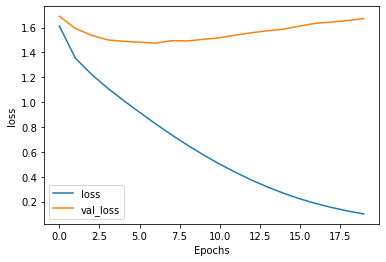

In [27]:
plot_graphs(history, 'loss')

### 베스트 모델 불러오기

In [28]:
DATA_OUT_PATH = './data_out/'
SAVE_FILE_NM = 'weights.h5'

model.load_weights(os.path.join(DATA_OUT_PATH, model_name, SAVE_FILE_NM))

### 모델 결과 출력하기

In [29]:
char2idx = prepro_configs['char2idx']
idx2char = prepro_configs['idx2char']

In [30]:
text = "남자친구 승진 선물로 뭐가 좋을까?"
test_index_inputs, _ = enc_processing([text], char2idx)
outputs = model.inference(test_index_inputs)

print(' '.join([idx2char[str(o)] for o in outputs]))

평소 에 필요했던게 좋을것 같아요


In [31]:
text = "친구 생일 선물로 뭐가 좋을까?"
test_index_inputs, _ = enc_processing([text], char2idx)
outputs = model.inference(test_index_inputs)

print(' '.join([idx2char[str(o)] for o in outputs]))

제 가 있잖아요


In [32]:
text = "친구 결혼 축하 선물로 뭐가 좋을까?"
test_index_inputs, _ = enc_processing([text], char2idx)
outputs = model.inference(test_index_inputs)

print(' '.join([idx2char[str(o)] for o in outputs]))

결혼 에 귀 기전 에 귀 기 도해 요
